<a href="https://colab.research.google.com/github/varshaelza/Text-Summarization-Categorization/blob/main/CNNBasedSummary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentence to Salience

In [ ]:
import pandas as pd
t = pd.read_csv('/content/drive/MyDrive/BBC Dataset/LDA Summarization/LDASummariestrain.csv') 

In [ ]:
t

,Unnamed: 0,News,Summary,Category_id,Type,Summary1,Length1,TextRankSumm,TextRankLen,Summary2,Length2,Summary1(Imp),Length1(Imp),Summary2(Imp),Length2(Imp),Summary3(Imp),Length3(Imp),Summary3.1(Imp),Length3.1(Imp)
0,0,Online games play with politics\n \n After bub...,"Dr Frasca said: ""Political campaigns will cont...",4,tech,Online games play with politics\nMany artists ...,2,Online games play with politics\n The US presi...,5,Online games play with politics\n,0,Online games play with politics\n After bubbli...,5,Online games play with politics\ncom.,1,Online games play with politics\n After bubbli...,5,Online games play with politics\n After bubbli...,3
1,1,Hague 'given up' his PM ambition\n \n Former C...,Mr Hague became an MP at 27 and Leader of the ...,2,politics,"Hague 'given up' his PM ambition\nMr Hague, wh...",4,"Hague 'given up' his PM ambition\n Mr Hague, 4...",5,"Hague 'given up' his PM ambition\nMr Hague, 43...",10,"Hague 'given up' his PM ambition\n Mr Hague, w...",5,"Hague 'given up' his PM ambition\n Mr Hague, ...",5,"Hague 'given up' his PM ambition\n Mr Hague, ...",5,"Hague 'given up' his PM ambition\n Mr Hague, ...",3
2,2,M&S cuts prices by average of 24%\n \n Marks &...,"""We are bringing in ranges at new price points...",0,business,"M&S cuts prices by average of 24%\n""We are bri...",7,"M&S cuts prices by average of 24%\n ""We are br...",5,M&S cuts prices by average of 24%\n,0,"M&S cuts prices by average of 24%\n ""We are br...",5,M&S cuts prices by average of 24%\n Many analy...,4,M&S cuts prices by average of 24%\n Marks & Sp...,5,M&S cuts prices by average of 24%\n Marks & Sp...,4
3,3,Zambia confident and cautious\n \n Zambia's te...,That victory for Angola also marked a first de...,3,sport,Zambia confident and cautious\nZambia have sho...,1,Zambia confident and cautious\n Zambia have sh...,5,Zambia confident and cautious\n Zambia's techn...,1,Zambia confident and cautious\n Bwalya said: ...,4,Zambia confident and cautious\n Zambia's techn...,1,Zambia confident and cautious\n Zambia's techn...,2,Zambia confident and cautious\n Zambia's techn...,2
4,4,Federer joins all-time greats\n \n The last ye...,Andy Roddick was the only player to put up any...,3,sport,Federer joins all-time greats\n The last year ...,12,Federer joins all-time greats\n The Swiss soun...,5,Federer joins all-time greats\n,0,Federer joins all-time greats\n His victory in...,5,Federer joins all-time greats\n,0,Federer joins all-time greats\n A quarter-fina...,5,Federer joins all-time greats\n A quarter-fina...,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775,1775,India seeks to boost construction\n \n India h...,"He said, ""No country can develop on the basis ...",0,business,India seeks to boost construction\n India has ...,10,India seeks to boost construction\n A spokesma...,5,India seeks to boost construction\n,0,India seeks to boost construction\n Analysts s...,5,India seeks to boost construction\n Analysts s...,3,India seeks to boost construction\n Analysts s...,5,India seeks to boost construction\n Analysts s...,4
1776,1776,Child access laws shake-up\n \n Parents who re...,Curfews and community service orders were othe...,2,politics,Child access laws shake-up\nCurfews and commun...,9,Child access laws shake-up\n Curfews and commu...,5,Child access laws shake-up\nThe constitutional...,16,Child access laws shake-up\n Curfews and commu...,5,Child access laws shake-up\n The constitutiona...,5,Child access laws shake-up\n The constitutiona...,5,Child access laws shake-up\n The constitutiona...,4
1777,1777,Parliament's record of scandal\n \n In a locke...,But divorces are by no means the only document...,2,politics,Parliament's record of scandal\nFor sprinkled ...,11,Parliament's record of scandal\n But divorces ...,5,Parliament's record of scandal\n In a locked r...,24,Parliament's record of scandal\n For sprinkled...,5,"Parliament's record of scandal\n Sex, betraya...",5,Parliament's record of scand

In [ ]:
t.drop(t.columns[t.columns.str.contains('unnamed',case= False)],axis=1,inplace=True)

In [ ]:
rawData = {}
#rawSummaries = {}
    
# running count variable -- keeps track of the total size
totalSentences = 0 

In [ ]:
def sep(text):
  import nltk
  nltk.download('punkt')
  import re
  text= text.replace("\t"," ")
  text=re.sub(r'\.+', '.',text)
  k=0
  c=0
  p=0
  a_list=[]
  while k<len(text):
    if c==0 and text[k]=='.':
      a_list.append(text[p:k+1])
      p=k+1
    elif c==0 and text[k]=='"':
      c=1
    elif c==1 and text[k]=='"' and text[k-1]=="." :
      a_list.append(text[p:k+1])
      p=k+1
      c=0
    elif c==1 and text[k]=='"' and text[k-2]=="." :
      a_list.append(text[p:k+1])
      p=k+1
      c=0
    elif c==1 and text[k]=='"':
      c=0
    k=k+1
  if p<len(text)-1:
    a_list.append(text[p:len(text)])
  return a_list
  

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize


In [ ]:
def spl(text):
  t=text.split('\n',1)
  if len(t)!=2:
    return ""
  else :
    return t[1]

In [ ]:
j=0
while j<len(t):
  a=sent_tokenize(t['News'][j])
  a[0]=spl(a[0])
  a[0]=spl(a[0])
  if a[0]=="":
    del a[0]
  i=0
  while i<len(a):
    a[i] = a[i].replace('\n',' ')
    a[i] = a[i].replace('\t',' ')
    a[i]= a[i].replace(r'\.+', ".")
    a[i]= a[i].replace(r'\ +', " ")
    i=i+1

  
  rawData[j]=a
  #rawSummaries[j]=b
  j=j+1


In [ ]:
rawData

{0: [' After bubbling under for some time, online games broke through onto the political arena in 2004.',
  'The US presidential election provided a showcase for many, aimed at talking directly to a generation that has grown up with joysticks and gamepads.',
  'Experts say this reflects how video games are becoming a mainstream part of culture and society.',
  'The first official political campaign game was technically launched during the last week of 2003: the Iowa Game, commissioned by the Democrat hopeful Howard Dean.',
  'More than 20 followed suit, including Frontrunner, eLections, President Forever and The Political Machine, which allowed players to run an entire presidential campaign, including having to cope with the media.',
  "Others helped raise the stakes during the Bush/Kerry contest by highlighting a candidate's virtues or his vices.",
  'The phenomenon has astonished the forefathers of political games, a handful of multi-discipline games enthusiasts keen to push frontier

In [ ]:
!pip install rouge/requirements.txt
!pip install rouge-score
import numpy as np

def calc_rouge_scores(pred_summaries, gold_summaries, 
                                 keys=['rouge1', 'rouge2'], use_stemmer=True):
    #Calculate rouge scores
    from rouge_score import rouge_scorer
    scorer = rouge_scorer.RougeScorer(keys, use_stemmer= use_stemmer)
    n = len(pred_summaries)
    scores = [scorer.score(pred_summaries[j], gold_summaries[j]) for 
              j in range(n)] 
              
    #create dict
    dict_scores={}                                                            
    for key in keys:
        dict_scores.update({key: {}})
        
    #populate dict    
    for key in keys:
        
        precision_list = [scores[j][key][0] for j in range(len(scores))]
        recall_list = [scores[j][key][1] for j in range(len(scores))]
        f1_list = [scores[j][key][2] for j in range(len(scores))]

        precision = np.mean(precision_list)
        recall = np.mean(recall_list)
        f1 = np.mean(f1_list)
        
        dict_results = {'recall': recall, 'precision': precision, 'f1': f1}
        
        dict_scores[key] = dict_results
        
    return dict_scores

ERROR: Invalid requirement: 'rouge/requirements.txt'
Hint: It looks like a path. File 'rouge/requirements.txt' does not exist.


In [ ]:
saliency={}
i=0
while i<len(rawData):
  saliency[i]=[]
  j=0
  while j<len(rawData[i]):
    s=calc_rouge_scores([rawData[i][j]],[t['Summary'][i]])
    saliency[i].append(0.5*s['rouge1']['f1']+s['rouge2']['f1']*0.5) #alpha=0.5
    j=j+1
  i=i+1

In [ ]:
tot=0;
i=0
while i<len(rawData):
  tot=tot+len(rawData[i])
  i=i+1

In [ ]:
import numpy as np
nx3output = np.zeros((tot, 3), dtype=object)

In [ ]:
i=0
c=0
while i<len(rawData):
  j=0
  while j<len(rawData[i]):
    nx3output[c,0]=i
    nx3output[c,1]=rawData[i][j]
    nx3output[c,2]=saliency[i][j]
    j=j+1
    c=c+1
  i=i+1


In [ ]:
import pickle
f = open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/sentencesToSaliency.pickle", "wb")
pickle.dump(nx3output, f)

In [ ]:
f.close()

In [ ]:
t

,News,Summary,Category_id,Type,Summary1,Length1,TextRankSumm,TextRankLen,Summary2,Length2,Summary1(Imp),Length1(Imp),Summary2(Imp),Length2(Imp),Summary3(Imp),Length3(Imp),Summary3.1(Imp),Length3.1(Imp)
0,Online games play with politics\n \n After bub...,"Dr Frasca said: ""Political campaigns will cont...",4,tech,Online games play with politics\nMany artists ...,2,Online games play with politics\n The US presi...,5,Online games play with politics\n,0,Online games play with politics\n After bubbli...,5,Online games play with politics\ncom.,1,Online games play with politics\n After bubbli...,5,Online games play with politics\n After bubbli...,3
1,Hague 'given up' his PM ambition\n \n Former C...,Mr Hague became an MP at 27 and Leader of the ...,2,politics,"Hague 'given up' his PM ambition\nMr Hague, wh...",4,"Hague 'given up' his PM ambition\n Mr Hague, 4...",5,"Hague 'given up' his PM ambition\nMr Hague, 43...",10,"Hague 'given up' his PM ambition\n Mr Hague, w...",5,"Hague 'given up' his PM ambition\n Mr Hague, ...",5,"Hague 'given up' his PM ambition\n Mr Hague, ...",5,"Hague 'given up' his PM ambition\n Mr Hague, ...",3
2,M&S cuts prices by average of 24%\n \n Marks &...,"""We are bringing in ranges at new price points...",0,business,"M&S cuts prices by average of 24%\n""We are bri...",7,"M&S cuts prices by average of 24%\n ""We are br...",5,M&S cuts prices by average of 24%\n,0,"M&S cuts prices by average of 24%\n ""We are br...",5,M&S cuts prices by average of 24%\n Many analy...,4,M&S cuts prices by average of 24%\n Marks & Sp...,5,M&S cuts prices by average of 24%\n Marks & Sp...,4
3,Zambia confident and cautious\n \n Zambia's te...,That victory for Angola also marked a first de...,3,sport,Zambia confident and cautious\nZambia have sho...,1,Zambia confident and cautious\n Zambia have sh...,5,Zambia confident and cautious\n Zambia's techn...,1,Zambia confident and cautious\n Bwalya said: ...,4,Zambia confident and cautious\n Zambia's techn...,1,Zambia confident and cautious\n Zambia's techn...,2,Zambia confident and cautious\n Zambia's techn...,2
4,Federer joins all-time greats\n \n The last ye...,Andy Roddick was the only player to put up any...,3,sport,Federer joins all-time greats\n The last year ...,12,Federer joins all-time greats\n The Swiss soun...,5,Federer joins all-time greats\n,0,Federer joins all-time greats\n His victory in...,5,Federer joins all-time greats\n,0,Federer joins all-time greats\n A quarter-fina...,5,Federer joins all-time greats\n A quarter-fina...,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775,India seeks to boost construction\n \n India h...,"He said, ""No country can develop on the basis ...",0,business,India seeks to boost construction\n India has ...,10,India seeks to boost construction\n A spokesma...,5,India seeks to boost construction\n,0,India seeks to boost construction\n Analysts s...,5,India seeks to boost construction\n Analysts s...,3,India seeks to boost construction\n Analysts s...,5,India seeks to boost construction\n Analysts s...,4
1776,Child access laws shake-up\n \n Parents who re...,Curfews and community service orders were othe...,2,politics,Child access laws shake-up\nCurfews and commun...,9,Child access laws shake-up\n Curfews and commu...,5,Child access laws shake-up\nThe constitutional...,16,Child access laws shake-up\n Curfews and commu...,5,Child access laws shake-up\n The constitutiona...,5,Child access laws shake-up\n The constitutiona...,5,Child access laws shake-up\n The constitutiona...,4
1777,Parliament's record of scandal\n \n In a locke...,But divorces are by no means the only document...,2,politics,Parliament's record of scandal\nFor sprinkled ...,11,Parliament's record of scandal\n But divorces ...,5,Parliament's record of scandal\n In a locked r...,24,Parliament's record of scandal\n For sprinkled...,5,"Parliament's record of scandal\n Sex, betraya...",5,Parliament's record of scandal\n Few realise ...,5,Parliament's reco

In [ ]:
t.to_csv('/content/drive/MyDrive/BBC Dataset/CNN Summarisation/CNNSummariestrain')

Embedding Sentences ith Word2Vec

In [16]:
!cd word2vec/
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

/bin/bash: line 0: cd: word2vec/: No such file or directory
--2021-05-13 08:49:02--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.16.11
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.16.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  69.6MB/s    in 23s     

2021-05-13 08:49:25 (69.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [17]:
import pickle

In [18]:
def loadFromPickle(fileName):
    f = open(fileName, "rb")
    data = pickle.load(f)
    f.close()
    return data 

In [19]:
data = loadFromPickle("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/sentencesToSaliency.pickle")

In [20]:
len(data)

33257

In [23]:
import gensim
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#def embed_sentences(data, word2vec_limit = 50000 , NUM_WORDS=20000):

In [24]:
def embed_sentences(data, word2vec_limit = 50000 , NUM_WORDS=20000):   
    '''
    Embed sentences
    Params:
        data             - np.array  [ doc id, sentences, saliency score ]
                            
        word2vec_limit   - int: number of words used in the word embedding provided by Google
                            - ex: 50000
        NUM_WORDS        - int: The maximum number of words to keep, based on word frequency. Only the most common num_words words will be kept.
                            - ex: 20000
       
    Returns:
        input_output        - np.array [embedding matrix , saliency score]
                        
    '''
    i=30000
    k=61
    while i<33000:
      #setences ex: ["It's the first sentence!","it is the second sentence"]
      sentences = data[:,1]
      
      #Load Google pre-trained words as a model
      embedding_model = gensim.models.KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin.gz', binary=True, limit=word2vec_limit)
      #Convert the model as a dictionnary word_vectors["hello"] will return a vector like [0.3, 3, ... , -4]
      word_vectors = embedding_model
      #print("Embedding for 'hello': ", word_vectors["hello"], "\n")
      
      # Tokenize the sentences, that is to say convert the 2 sentences ["It's the first sentence!","It is the second sentence"] to 2 sequences [[1 4 2 5 3],[1 6 2 7 3]]
      # It handles the ennoying cases (punctuation, Upper cases, etc...)
      tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)
      tokenizer.fit_on_texts(sentences)
      sequences = tokenizer.texts_to_sequences(sentences)
      padded_sequences = pad_sequences(sequences)
      #print("Padded_sequences: ", padded_sequences, "\n")   
      
      #Produce a dictionnary mapping words to tokens e.g. {'it': 1, 'the': 2, 'sentence': 3, 's': 4, 'first': 5, 'is': 6, 'second': 7}
      word_index = tokenizer.word_index
      #print("word_index: " , word_index , "\n" )
      
      #Build a dictionnary mapping tokens to vectors e.g. {'1': [2, ... , -3] ; '2': [4, ... , 0.8] ; ... }
      embedding_weights = {key: embedding_model[word] if word in word_vectors.vocab else
                                np.random.uniform(-0.25, 0.25, word_vectors.vector_size)
                          for word, key in word_index.items()}
      # Add the token "0", used for padding
      embedding_weights[0] = np.zeros(word_vectors.vector_size)
    
      #print("Embedding weights: " , embedding_weights , "\n")
      
      #Build a 3D array: 1D for the sentences, 1D for the words and 1D for the word2vec dimensions.
      print('hey1')
      del sequences
      del embedding_model
      p= padded_sequences[i:i+500]
      del padded_sequences
      print('hey2')
      embedded_sentences = np.stack([np.stack([embedding_weights[token] for token in sentence]) for sentence in p])
      print('hey3')
      del p
      del embedding_weights
      i=i+500
      input_output = np.array([])
      j=i-500
      while j<i:
        input_output = np.append(input_output,np.array([ embedded_sentences[j-(i-500)] , data[j,2] ]) )
        j=j+1
      f = open('/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency'+str(k)+'.pickle', "wb")
      pickle.dump(input_output,f)
      
      k=k+1
      
      del embedded_sentences
      del input_output

    
      #Add back the saliency scores
      #input_output = np.column_stack((embedded_sentences,data[:,2]))    
      
      #input_output = np.array([])
      #for i in range(len(data)):
      #   input_output = np.append(input_output,np.array([ embedded_sentences[i] , data[i,2] ]) )
          
      
      
      #return input_output

In [27]:
embed_sentences(data)

hey1
hey2
hey3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


CNN Model Bilding and training using Keras.Training is done in stages due to large size of Word2Vec  embeddings of data

In [1]:
import pickle
import numpy as np

In [28]:
#data31 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency31.pickle", "rb"))
#data32 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency32.pickle", "rb"))
#data33 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency33.pickle", "rb"))
#data34 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency34.pickle", "rb"))
#data35 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency35.pickle", "rb"))
#data36 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency36.pickle", "rb"))
#data37 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency37.pickle", "rb"))
#data38 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency38.pickle", "rb"))
#data39 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency39.pickle", "rb"))
#data40 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency40.pickle", "rb"))
#data41 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency41.pickle", "rb"))
#data42 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency42.pickle", "rb"))
#data43 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency43.pickle", "rb"))
#data44 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency44.pickle", "rb"))
#data45 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency45.pickle", "rb"))
#data46 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency46.pickle", "rb"))
#data47 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency47.pickle", "rb"))
#data48 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency48.pickle", "rb"))
#data49 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency49.pickle", "rb"))
#data50 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency50.pickle", "rb"))
data61 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency61.pickle", "rb"))
data62 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency62.pickle", "rb"))
data63 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency63.pickle", "rb"))
data64 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency64.pickle", "rb"))
data65 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency65.pickle", "rb"))
data66 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency66.pickle", "rb"))
data67 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency67.pickle", "rb"))
#data58 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency58.pickle", "rb"))
#data59 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency59.pickle", "rb"))
#data60 = pickle.load(open("/content/drive/MyDrive/BBC Dataset/CNN Summarisation/embeddingsToSaliency60.pickle", "rb"))

In [29]:
data = np.concatenate((data61,data62,data63,data64,data65,data66,data67), axis=0)

In [30]:
del data67,data66,data65,data64,data63,data62,data61

In [31]:
x = data[::2]
y = data[1::2]
del data

In [32]:
from sklearn.utils import shuffle
x = np.dstack(x)
x = np.rollaxis(x, -1)
x = np.expand_dims(x, axis=1)

mask = y==-1

print("removing -1s...")
x = x[~mask, :]
y = y[~mask]

print("data loaded.")
x, y = shuffle(x, y)

removing -1s...
data loaded.


In [33]:
conv_window_size = (1, 300)
num_filters = 100
reg = 0.01
dropout = 0.5

epochs = 10
batch_size = 16
val_train_ratio = 0.2

In [34]:
#import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras import regularizers
from keras.optimizers import Adadelta
def build_model(input_shape, conv_window_size, num_filters, reg, dropout):
    model = Sequential()
    #model.add(Embedding(max_features,300))

    # we add a Convolution 1D, which will learn num_filters
    # word group filters of size conv_window_size:
    model.add(Conv2D(input_shape=input_shape,
                        filters=num_filters,
                        kernel_size=conv_window_size,
                        padding="same",
                        activation="relu",
                        strides=1,
                        ))
    
    model.add(MaxPooling2D(pool_size=(num_filters, 1) ,padding="same")  ) 
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(reg)))
    
    #In addition, an l2−norm constraint of the weights w_r is imposed during training as well

    model.compile(loss='binary_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['mae'])
    return model

In [35]:
def train(model, x_train, y_train, val_train_ratio=0.2, epochs=1000, batch_size=128):
    from keras.callbacks import ModelCheckpoint
    filepath="weights-improvement-{epoch:02d}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
    callbacks_list = [checkpoint]
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_train_ratio,
                        shuffle=False,
                        callbacks=callbacks_list,
                        verbose=1)
    return history

In [36]:
from keras import backend as K
x = K.cast_to_floatx(x)
y = K.cast_to_floatx(y)

In [37]:
print(x.shape)

(3257, 1, 290, 300)


In [38]:
import tensorflow as tf
#images_nhwc = tf.placeholder(tf.float32, [None, 200, 300, 3])  # input batch
out = tf.transpose(x, [0, 2, 3, 1])
print(out.get_shape())
x=out
del out  # the shape of out is [None, 3, 200, 300]

(3257, 290, 300, 1)


In [39]:
x1=x
y1=y

In [41]:
import keras
model=keras.models.load_model('/content/drive/MyDrive/BBC Dataset/CNN Summarisation/Models/model6-basic.h5')

Epoch 1/10
163/163 [==============================] - 1394s 9s/step - loss: 0.3831 - mae: 0.0935 - val_loss: 0.3736 - val_mae: 0.0919

Epoch 00001: saving model to weights-improvement-01.hdf5
Epoch 2/10
163/163 [==============================] - 1385s 9s/step - loss: 0.3830 - mae: 0.0934 - val_loss: 0.3735 - val_mae: 0.0919

Epoch 00002: saving model to weights-improvement-02.hdf5
Epoch 3/10
163/163 [==============================] - 1386s 9s/step - loss: 0.3827 - mae: 0.0934 - val_loss: 0.3734 - val_mae: 0.0918

Epoch 00003: saving model to weights-improvement-03.hdf5
Epoch 4/10
163/163 [==============================] - 1386s 9s/step - loss: 0.3826 - mae: 0.0932 - val_loss: 0.3733 - val_mae: 0.0918

Epoch 00004: saving model to weights-improvement-04.hdf5
Epoch 5/10
163/163 [==============================] - 1369s 8s/step - loss: 0.3826 - mae: 0.0933 - val_loss: 0.3731 - val_mae: 0.0917

Epoch 00005: saving model to weights-improvement-05.hdf5
Epoch 6/10
163/163 [====================

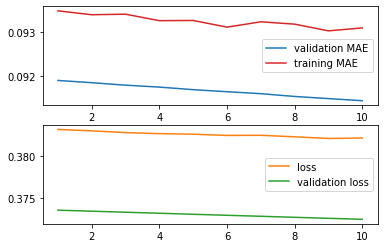

Done.


In [42]:
#model = build_model(( x1.shape[1], x1.shape[2],1), conv_window_size, num_filters, reg, dropout)

history = train(model, x1, y1, val_train_ratio, epochs, batch_size)

import matplotlib.pyplot as plt

print("Saving model...")
model.save('/content/drive/MyDrive/BBC Dataset/CNN Summarisation/Models/model7-basic.h5')

print("Plotting...")
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(1, epochs+1), history.history['val_mae'], 'tab:blue', label="validation MAE")
ax1.plot(range(1, epochs+1), history.history['mae'], 'tab:red', label="training MAE")

ax2.plot(range(1, epochs+1), history.history['loss'], 'tab:orange', label="loss")
ax2.plot(range(1, epochs+1), history.history['val_loss'], 'tab:green', label="validation loss")

ax1.legend()
ax2.legend()

f.savefig('/content/drive/MyDrive/BBC Dataset/CNN Summarisation/Models/training-model7-basic.png', dpi=300)
plt.show()
m=keras.models.load_model('/content/weights-improvement-10.hdf5')
m.save('/content/drive/MyDrive/BBC Dataset/CNN Summarisation/Models/weights7_basic.hdf5')

print("Done.")

Testing 

In [46]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/BBC Dataset/CNN Summarisation/CNNSummarisation_test (1).csv') 

In [47]:
train

,Unnamed: 0,News,Summary,Category_id,Type,Summary1,Length1,TextRankSumm,TextRankLen,Summary2,Length2,Summary1(Imp),Length1(Imp),Summary2(Imp),Length2(Imp),Summary3(Imp),Length3(Imp),Summary3.1(Imp),Length3.1(Imp),CNN(Basic)
0,0,Labour battle plan 'hides Blair'\n \n The Tori...,Mr Milburn said the economy would take centre ...,2,politics,Labour battle plan 'hides Blair'\nInstead Mr B...,5,Labour battle plan 'hides Blair'\n In a break ...,5,Labour battle plan 'hides Blair'\nIn a break w...,19,Labour battle plan 'hides Blair'\n Instead Mr ...,5,Labour battle plan 'hides Blair'\n In a break...,5,Labour battle plan 'hides Blair'\n The Tories ...,5,Labour battle plan 'hides Blair'\n The Tories ...,4,Labour battle plan 'hides Blair'\nHe promised ...
1,1,Tutu's Guantanamo release call\n \n Archbishop...,The South African archbishop said detentions w...,2,politics,Tutu's Guantanamo release call\n Archbishop De...,2,Tutu's Guantanamo release call\n His comments ...,5,Tutu's Guantanamo release call\n Archbishop De...,20,Tutu's Guantanamo release call\n Archbishop De...,5,Tutu's Guantanamo release call\n Archbishop De...,5,Tutu's Guantanamo release call\n Archbishop De...,5,"Tutu's Guantanamo release call\n"" Following Mr...",1,Tutu's Guantanamo release call\nThe Britons we...
2,2,Holmes starts 2005 with GB events\n \n Kelly H...,Holmes will make her first track appearance on...,3,sport,Holmes starts 2005 with GB events\nHolmes will...,3,Holmes starts 2005 with GB events\n Holmes wil...,5,Holmes starts 2005 with GB events\n Kelly Holm...,1,Holmes starts 2005 with GB events\n Holmes wi...,5,Holmes starts 2005 with GB events\n Kelly Holm...,1,Holmes starts 2005 with GB events\n Holmes wi...,4,"Holmes starts 2005 with GB events\n ""I am stil...",2,Holmes starts 2005 with GB events\n Kelly Holm...
3,3,Tory expert denies defeatism\n \n The Conserva...,Mr Howard appointed Mr Crosby as his elections...,2,politics,Tory expert denies defeatism\n,0,Tory expert denies defeatism\n The Times on Mo...,5,Tory expert denies defeatism\nBut Mr Crosby sa...,5,Tory expert denies defeatism\n But Mr Crosby s...,5,Tory expert denies defeatism\n But Mr Crosby s...,5,Tory expert denies defeatism\n The Times on M...,5,Tory expert denies defeatism\n The Times on M...,2,Tory expert denies defeatism\nBut Mr Crosby sa...
4,4,Movie body targets children's PCs\n \n The bod...,The Movie Association for America's (MPAA) fre...,4,tech,Movie body targets children's PCs\n The body t...,9,Movie body targets children's PCs\n The Movie ...,5,Movie body targets children's PCs\n,0,Movie body targets children's PCs\n It will al...,5,Movie body targets children's PCs\n,0,"Movie body targets children's PCs\n ""Many pare...",5,"Movie body targets children's PCs\n ""Many pare...",4,Movie body targets children's PCs\nIt will als...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,440,NHS waiting time target is cut\n \n Hospital w...,"""But let us not forget two thirds of those wai...",2,politics,NHS waiting time target is cut\nWelsh Health M...,14,"NHS waiting time target is cut\n On Wednesday,...",5,NHS waiting time target is cut\n Hospital wait...,22,NHS waiting time target is cut\n Welsh Health...,5,NHS waiting time target is cut\n Hospital wait...,5,"NHS waiting time target is cut\n In England, t...",5,"NHS waiting time target is cut\n In England, t...",4,NHS waiting time target is cut\nThe announceme...
441,441,Baron Kinnock makes Lords debut\n \n Former La...,Former Labour leader Neil Kinnock has official...,2,politics,Baron Kinnock makes Lords debut\n Former Labou...,6,Baron Kinnock makes Lords debut\n He will be k...,5,Baron Kinnock makes Lords debut\n Former Labou...,13,Baron Kinnock makes Lords debut\n Former Labou...,5,Baron Kinnock makes Lords debut\n Former Labou...,5,Baron Kinnock makes Lords debut\n Former Labou...,5,Baron Kinnock makes Lords debut\n Lord Kinnock...,3,Baron Kinnock makes Lords debut\nHe will be kn...
442,442,Player 

In [4]:
import keras
model=keras.models.load_model('/content/drive/MyDrive/BBC Dataset/CNN Summarisation/Models/model7-basic.h5')

In [5]:
#model = build_model(( 290,300,1), conv_window_size, num_filters, reg, dropout)
for layer in model.layers: print(layer.get_config(),layer.get_weights())

{'name': 'conv2d', 'trainable': True, 'batch_input_shape': (None, 290, 300, 1), 'dtype': 'float32', 'filters': 100, 'kernel_size': (1, 300), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[[[-0.00631811, -0.01437289,  0.01186065, ...,  0.00600973,
           0.00150005,  0.008324  ]],

        [[ 0.01205557, -0.007023  ,  0.00304833, ...,  0.00719786,
           0.00085633,  0.01300636]],

        [[-0.01034518,  0.01322458,  0.00538462, ...,  0.00820491,
           0.00025811,  0.01371292]],

        ...,

        [[ 0.01182735,  0.00357896,  0.00109671, ..., -0.00933942,
           0.00340205, -0.00239733]

In [6]:
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
def spl(text):
  t=text.split('\n',1)
  if len(t)!=2:
    return ""
  else :
    return t[1]

In [8]:
 def get_Sent(t) :
  a=sent_tokenize(t)
  a[0]=spl(a[0])
  a[0]=spl(a[0])
  if a[0]=="":
    del a[0]
  i=0
  while i<len(a):
    a[i] = a[i].replace('\n',' ')
    a[i] = a[i].replace('\t',' ')
    a[i]= a[i].replace(r'\.+', ".")
    a[i]= a[i].replace(r'\ +', " ")
    i=i+1
  return a


In [9]:
train['CNN(Basic)']=""

In [10]:
train.drop(train.columns[train.columns.str.contains('unnamed',case= False)],axis=1,inplace=True)

In [11]:
import numpy as np

In [12]:
import gensim
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#def embed_sentences(data, word2vec_limit = 50000 , NUM_WORDS=20000):

In [13]:
!cd word2vec/
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

/bin/bash: line 0: cd: word2vec/: No such file or directory
--2021-05-13 15:18:36--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.243.22
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.243.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  16.2MB/s    in 1m 42s  

2021-05-13 15:20:19 (15.3 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [14]:
def embed_sentences(data, word2vec_limit = 50000 , NUM_WORDS=20000):   

  #setences ex: ["It's the first sentence!","it is the second sentence"]
  sentences = data
  
  #Load Google pre-trained words as a model
  embedding_model = gensim.models.KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin.gz', binary=True, limit=word2vec_limit)
  #Convert the model as a dictionnary word_vectors["hello"] will return a vector like [0.3, 3, ... , -4]
  word_vectors = embedding_model
  #print("Embedding for 'hello': ", word_vectors["hello"], "\n")
  
  # Tokenize the sentences, that is to say convert the 2 sentences ["It's the first sentence!","It is the second sentence"] to 2 sequences [[1 4 2 5 3],[1 6 2 7 3]]
  # It handles the ennoying cases (punctuation, Upper cases, etc...)
  tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)
  tokenizer.fit_on_texts(sentences)
  sequences = tokenizer.texts_to_sequences(sentences)
  padded_sequences = pad_sequences(sequences)
  #print("Padded_sequences: ", padded_sequences, "\n")   
  
  #Produce a dictionnary mapping words to tokens e.g. {'it': 1, 'the': 2, 'sentence': 3, 's': 4, 'first': 5, 'is': 6, 'second': 7}
  word_index = tokenizer.word_index
  #print("word_index: " , word_index , "\n" )
  
  #Build a dictionnary mapping tokens to vectors e.g. {'1': [2, ... , -3] ; '2': [4, ... , 0.8] ; ... }
  embedding_weights = {key: embedding_model[word] if word in word_vectors.vocab else
                            np.random.uniform(-0.25, 0.25, word_vectors.vector_size)
                      for word, key in word_index.items()}
  # Add the token "0", used for padding
  embedding_weights[0] = np.zeros(word_vectors.vector_size)

  #print("Embedding weights: " , embedding_weights , "\n")
  
  #Build a 3D array: 1D for the sentences, 1D for the words and 1D for the word2vec dimensions.
  print('hey1')
  del sequences
  del embedding_model
  
  print('hey2')
  embedded_sentences = np.stack([np.stack([embedding_weights[token] for token in sentence]) for sentence in padded_sequences])
  print('hey3')
  return embedded_sentences

In [37]:
#924
i

1365

In [41]:
#i=0
while i<len(train):
  testing_data = [ [ np.array(get_Sent(train['News'][i])), 
                       np.random.rand(len(get_Sent(train['News'][i])),300,1), 
                       np.array([train['Summary'][i]]) ]
                     ]

  
  doc=testing_data[0] 
  sentences = doc[0]
  x_test = embed_sentences(sentences)
  q=0

  try:
    x_test = np.array( [ np.pad(x_test, ((0,0),(290-x_test.shape[1],0),(0,0)), 'constant') ] )
  except:
    print('hello')
    x_test=np.array(x_test)
    x_test=np.array(x_test[0:x_test.shape[0],0:290,0:x_test.shape[2]])

  import tensorflow as tf
  #images_nhwc = tf.placeholder(tf.float32, [None, 200, 300, 3])  # input batch
  out = tf.transpose(x_test, [1, 2, 3, 0])
  print(out.get_shape())
  x_test=out
  del out  # the shape of out is [None, 3, 200, 300]
  print(x_test.shape)
  true_summary = doc[2]
  
  predicted_scores = model.predict(x_test, batch_size=16)
  print(predicted_scores)
  res = sorted(range(len(predicted_scores)), key = lambda sub: predicted_scores[sub])[-5:]
  #argsorted_scores= np.argsort(predicted_scores)
  #argsorted_scores = np.argpartition(np.transpose(predicted_scores)[0], 1)
  #print(argsorted_scores)
  res.sort()
  print(res)
  predicted_summary=""
  
  j = 0
  
  while j < 5 and j<len(res): 
      sentence = sentences[res[j]]
      #if ( dummy_rouge( sentence , predicted_summary ) < threshold ):
      sentence = np.array([sentence])
      #print(sentence, predicted_summary)
      predicted_summary=predicted_summary+sentence[0]
      
      j=j+1
  t=train['News'][i].split('\n',1)

  train['CNN(Basic)'][i]=t[0]+'\n'+predicted_summary 
  i=i+1 
train.to_csv('/content/drive/MyDrive/BBC Dataset/CNN Summarisation/CNNSummarisation_test.csv')

hey1
hey2
hey3
(22, 290, 300, 1)
(22, 290, 300, 1)
[[0.1012311 ]
 [0.11288804]
 [0.11194134]
 [0.12723932]
 [0.10119373]
 [0.11190942]
 [0.12003833]
 [0.12630254]
 [0.12856567]
 [0.113493  ]
 [0.10405219]
 [0.11485663]
 [0.11871567]
 [0.11290506]
 [0.13788438]
 [0.12177131]
 [0.11090782]
 [0.13193113]
 [0.10904041]
 [0.1193096 ]
 [0.1190578 ]
 [0.10533923]]
[3, 7, 8, 14, 17]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Streaming output truncated to the last 5000 lines.
 [0.16750723]
 [0.11923304]
 [0.16046244]
 [0.1293514 ]
 [0.10641444]
 [0.13418135]
 [0.13819739]
 [0.13484761]
 [0.11637291]
 [0.13091439]
 [0.11579412]
 [0.08947158]
 [0.10651213]
 [0.10456437]
 [0.14699996]
 [0.09675461]
 [0.11349484]
 [0.15085188]
 [0.10444796]
 [0.1787878 ]
 [0.08802381]
 [0.13917473]
 [0.14612398]
 [0.10434404]
 [0.11874413]
 [0.12550992]
 [0.11931124]
 [0.13311279]
 [0.14795646]
 [0.08224058]
 [0.11136469]
 [0.10381585]
 [0.09497911]
 [0.11236581]
 [0.08723894]
 [0.11092749]
 [0.1188947 ]
 [0.13559178]]
[6, 44, 103, 119, 149]
hey1
hey2
hey3
(12, 290, 300, 1)
(12, 290, 300, 1)
[[0.11601734]
 [0.1382589 ]
 [0.11059418]
 [0.10805973]
 [0.11766964]
 [0.12789488]
 [0.17079756]
 [0.2694447 ]
 [0.27865922]
 [0.1326968 ]
 [0.11386317]
 [0.0843333 ]]
[1, 6, 7, 8, 9]
hey1
hey2
hey3
(15, 290, 300, 1)
(15, 290, 300, 1)
[[0.11107808]
 [0.11433002]
 [0.10511842]
 [0.13972491]
 [0.12071902]
 [0.12342036]
 [0.10776544]
 [0.1064

In [17]:
!pip install rouge/requirements.txt
!pip install rouge-score
import numpy as np

def calc_rouge_scores(pred_summaries, gold_summaries, 
                                 keys=['rouge1', 'rouge2'], use_stemmer=True):
    #Calculate rouge scores
    from rouge_score import rouge_scorer
    scorer = rouge_scorer.RougeScorer(keys, use_stemmer= use_stemmer)
    n = len(pred_summaries)
    scores = [scorer.score(pred_summaries[j], gold_summaries[j]) for 
              j in range(n)] 
              
    #create dict
    dict_scores={}                                                            
    for key in keys:
        dict_scores.update({key: {}})
        
    #populate dict    
    for key in keys:
        
        precision_list = [scores[j][key][0] for j in range(len(scores))]
        recall_list = [scores[j][key][1] for j in range(len(scores))]
        f1_list = [scores[j][key][2] for j in range(len(scores))]

        precision = np.mean(precision_list)
        recall = np.mean(recall_list)
        f1 = np.mean(f1_list)
        
        dict_results = {'recall': recall, 'precision': precision, 'f1': f1}
        
        dict_scores[key] = dict_results
        
    return dict_scores

ERROR: Invalid requirement: 'rouge/requirements.txt'
Hint: It looks like a path. File 'rouge/requirements.txt' does not exist.


In [43]:
#train basic model
score=calc_rouge_scores(train['CNN(Basic)'],train['Summary'])
score

{'rouge1': {'f1': 0.40045468714282917,
  'precision': 0.3359216695376848,
  'recall': 0.6077028821262591},
 'rouge2': {'f1': 0.24459745712531275,
  'precision': 0.21368795716587882,
  'recall': 0.34265804470757716}}

In [48]:
#test basic model
score=calc_rouge_scores(train['CNN(Basic)'],train['Summary'])
score

{'rouge1': {'f1': 0.410141753035883,
  'precision': 0.34646297882893345,
  'recall': 0.6124089717742877},
 'rouge2': {'f1': 0.2570679857062539,
  'precision': 0.2255736665680491,
  'recall': 0.35703262515386774}}

In [49]:
train.to_csv('/content/drive/MyDrive/BBC Dataset/CNN Summarisation/CNNSummarisation_test.csv')